In [1]:
import numpy as np
import nlp as nlp_hlp
import helpers_and_variables as hlp
import ML_helpers as ml_hlp
import random
import re
import pandas as pd
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.cross_decomposition import PLSRegression
from pyopls import OPLS
from sklearn.metrics import roc_auc_score, f1_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

np.random.seed(0)

import scipy
from scipy.stats import randint
from sklearn.utils.fixes import loguniform

import warnings
warnings.filterwarnings("ignore")
labels = hlp.load_list_from_json_file(".../labels.json")


In [8]:
"""
read the data
"""

dict_path = ".../dict_all"
dict_all = hlp.load_dict_from_json_file(dict_path)

dict_path = ".../dict_70V"
dict_70v = hlp.load_dict_from_json_file(dict_path)
dict_path = ".../dict_63D"
dict_63d = hlp.load_dict_from_json_file(dict_path)
dict_path = ".../dict_7B"
dict_7b = hlp.load_dict_from_json_file(dict_path)

# TFIDF

started for suffix and digits combs,  True False
Number of features for each patient is:  2135
The set with trimm True and without digits False done.
Best test models:  ['svm']
With test scores:  [0.5848595848595849]

started for suffix and digits combs,  True True
Number of features for each patient is:  1204
The set with trimm True and without digits True done.
Best test models:  ['rf']
With test scores:  [0.5879120879120879]



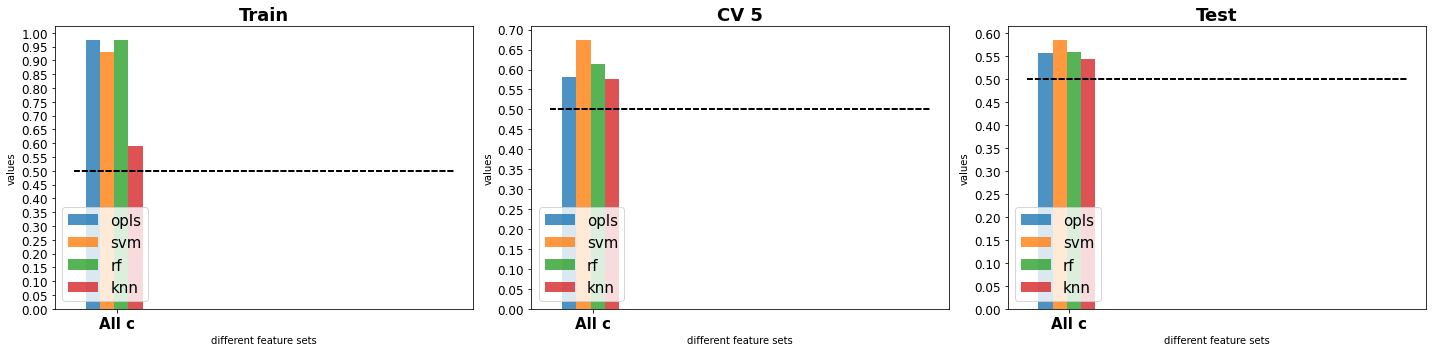

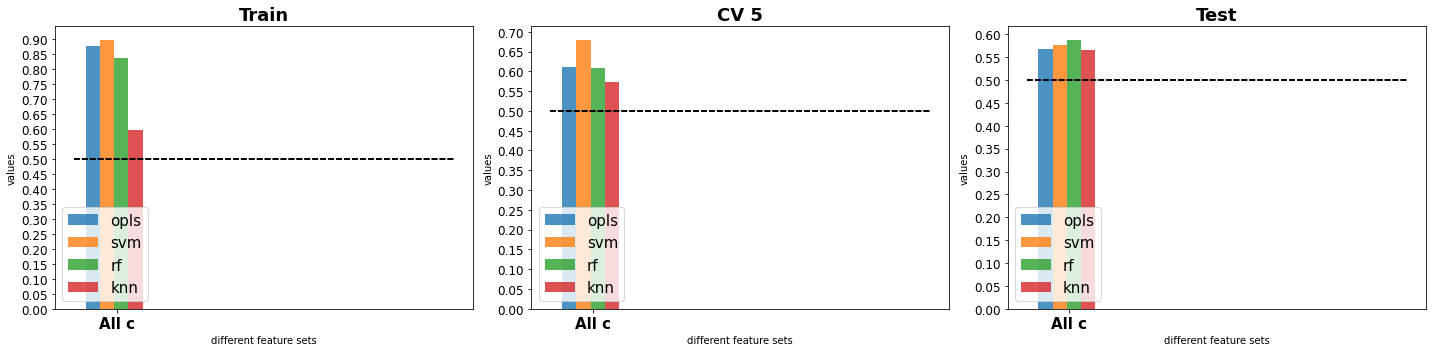

In [10]:
combinations = [(True, False), (True, True)]
all_test_dicts = dict()
vectorizer = 'tfidf'
random_state = 42
cv=5
split_size = 0.2
n_iter = 220
dicts = [dict_all, dict_70v, dict_63d, dict_7b]
dict_names = ['All', '70 variables','63 descriptors', '7 b']

for combs in combinations:
    suffix_41 = combs[0]
    without_digits = combs[1]
    print("started for suffix and digits combs, ", suffix_41, without_digits)
    results = dict(); opls_dict = dict(); svm_dict = dict(); rf_dict = dict(); knn_dict = dict(); mlp_dict = dict(); 
    dict_best_params = dict()

    best_test = [0 for i in range(len(dict_names))]
    best_test_model = ['' for i in range(len(dict_names))]

    for _dict in range(len(dicts)):
        data_list, corpus_sentenses, corpus_sentenses_tokenized = nlp_hlp.get_data_from_main_dict(dicts[_dict], stemm=True, 
            return_corpus_sent=True, return_corpus_token=False, without_digits=without_digits, suffix_41=suffix_41)

        x_train, x_test, y_train, y_test = ml_hlp.get_train_test_split_data(data_list, labels, stratify = labels,
                                                      test_size=split_size, random_state=random_state, shuffle = True)

        vectorizer = ml_hlp.get_tfidf_vectorization_model(corpus_sentenses)
    #     features = vectorizer.get_feature_names_out()
        print("Number of features for each patient is: ", len(vectorizer.get_feature_names_out()))

        all_data_vectorized = ml_hlp.get_tfidf_vectorized_data(tfidf_model=vectorizer,
                                                          to_be_vectorized_data=data_list)

        all_data_vectorized = ml_hlp.get_csr_matrix(all_data_vectorized)
        min_max = preprocessing.MinMaxScaler()

        min_max = min_max.fit(all_data_vectorized)
        del all_data_vectorized

        X_train_vectorized = ml_hlp.get_tfidf_vectorized_data(tfidf_model=vectorizer,
                                                              to_be_vectorized_data=x_train)
        X_test_vectorized = ml_hlp.get_tfidf_vectorized_data(tfidf_model=vectorizer, 
                                                            to_be_vectorized_data=x_test)

        X_train = min_max.transform(ml_hlp.get_csr_matrix(X_train_vectorized))
        X_test = min_max.transform(ml_hlp.get_csr_matrix(X_test_vectorized))

        Y_train = np.array(y_train, dtype='float')
        Y_test = np.array(y_test, dtype='float')
        del X_train_vectorized, X_test_vectorized, min_max

        ## OPLS
        opls = OPLS(2)
        opls.fit(X_train, Y_train)
        z_train = opls.transform(X_train)
        z_test = opls.transform(X_test)
        pls = PLSRegression(1)
        pls.fit(z_train, Y_train)

        y_pred = cross_val_predict(pls, z_train, Y_train, cv=StratifiedKFold(cv))
        threshed_values = np.array(y_pred)
        best = 0
        best_thresh = 0
        for thresh in np.unique(y_pred):
            threshed_values[y_pred<thresh]=1
            threshed_values[y_pred>=thresh]=2
            score = roc_auc_score(Y_train, threshed_values)
            if score > best:
                best=score
                best_thresh=thresh
                
        std = y_pred[y_pred>=best_thresh].std()
        
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        cv_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_train)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        train_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_test)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        test_score = roc_auc_score(Y_test, y_pred)
        f1_Score = f1_score(Y_test, y_pred, average='weighted')
        
        dict_best_params['opls '+ dict_names[_dict]] = {'best_thresh': best_thresh}
        
        opls_dict[dict_names[_dict]] = {'Train': [train_score], 
                            'CV 5': [cv_score, std],
                            'Test' : [test_score, f1_Score]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'opls'

        del opls, pls

        ## SVM
        svm = SVC(probability=True, 
              random_state=random_state, class_weight = "balanced")

        param_distributions = {"gamma": loguniform(0.0001, 2),
                               "kernel": ['rbf', 'linear'],
                               "degree": [2,3],
                               "C": loguniform(0.001, 2)#, #[0.001, 0.01, 0.03, 0.1, 1, 2]
                               }
        search = RandomizedSearchCV(svm, param_distributions,
                                       n_iter= n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score='raise',
                                       random_state=random_state).fit(X_train, Y_train)
        svm = search.best_estimator_
        dict_best_params['svm '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(svm, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, svm)

        svm_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, svm)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, svm.predict(X_test), average='weighted')]}
        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'svm'
        del svm

        ## RandomForest
        rf = RandomForestClassifier(random_state=random_state, 
                                    class_weight = "balanced", 
                                    max_features='auto',
                                    criterion='entropy')

        param_distributions = {"max_depth": [1, 2, 3, None],
                               "min_samples_split": randint(2, 14),
                               "min_samples_leaf": randint(1, 14),
                               "ccp_alpha": loguniform(0.0001, 1)
    #                            "max_features": ['auto', 'sqrt','log2']
                              }
        search = RandomizedSearchCV(rf, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)
        rf = search.best_estimator_
        dict_best_params['rf '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(rf, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, rf)
        rf_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, rf)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score, f1_score(Y_test, rf.predict(X_test), average='weighted')]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'rf'

        del rf

        ## KNeighbors
        knn = KNeighborsClassifier()
        param_distributions = {"n_neighbors": [3,4,5,7,10],
                               "weights": ['uniform', 'distance'],
                               "leaf_size": list(range(1,12)),
                               "p": list(range(1,3))
                              }
        search = RandomizedSearchCV(knn, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        knn = search.best_estimator_
        dict_best_params['knn '+ dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(knn, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, knn)
        knn_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, knn)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, knn.predict(X_test), average='weighted')]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'knn'

        del knn

        ## MLP
        mlp = MLPClassifier(random_state=random_state, max_iter=1200, 
                            learning_rate='adaptive', batch_size='auto',
                            early_stopping=True);

        param_distributions = {"hidden_layer_sizes": [(7,3), (5,2), (100,)],
                               "activation": ['tanh', 'logistic','relu'],
                               "solver": ['adam', 'lbfgs'],
                               "alpha":  loguniform(0.0001, 1)
                               };

        search = RandomizedSearchCV(mlp, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        mlp = search.best_estimator_
        dict_best_params['mlp '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(mlp, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, mlp)
        mlp_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, mlp)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, mlp.predict(X_test))]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'mlp'

    #     print('%d dict is done'%_dict)
        del X_train, Y_train, X_test, Y_test
    print("The set with trimm {0} and without digits {1} done.".format(str(suffix_41), str(without_digits)))
    print("Best test models: ", best_test_model)
    print("With test scores: ", best_test)
    print("")
    #############################################################################
    to_be_saved_dicts = [opls_dict, svm_dict, rf_dict, knn_dict]#, mlp_dict]
    names = ['opls', 'svm', 'rf', 'knn']#, 'mlp']
    save_file_name = r"...\MEX\PekLung\results\tfidf\new"

    for i in range(len(to_be_saved_dicts)):
        results[names[i]] = to_be_saved_dicts[i]
    file_path = save_file_name + r"\best_results\with_text_trimm_{0}_digits_{1}".format(str(suffix_41), str(without_digits)) 

    hlp.write_dict_as_json_file(results, 
                                file_path = file_path)

    file_path = save_file_name + r"\best_params\with_text_trimm_{0}_digits_{1}".format(str(suffix_41), str(without_digits)) 
    hlp.write_dict_as_json_file(dict_best_params, 
                                file_path = file_path)
    ###############################################################################
    approaches = list(results.keys()) # ['opls', 'svm', 'rf', 'knn', 'mlp']
    sets_names = list(results[approaches[0]].keys()) 
    x_labels = [set_name[0:5] for set_name in sets_names] # ['All', '70 va', '7 b', '63 de']
    splits_names = list(results[approaches[0]][sets_names[0]].keys()) # ['Train', 'CV 6', 'Test']
    plot_dict = dict()
    for split in splits_names:
        tmp_dict_approach = dict()
        for approach_idx in range(len(approaches)):
            df = pd.DataFrame(results[approaches[approach_idx]])
            tmp_dict_set = dict()
            for column in df.columns:
                tmp_dict_set[column] = df.loc[split, column][0]
            tmp_dict_approach[approaches[approach_idx]] = tmp_dict_set
        plot_dict[split] = tmp_dict_approach

    plt.figure(figsize=(20,5))
    for i in range(len(splits_names)):
        split_name = splits_names[i]
        result_df = pd.DataFrame(plot_dict[split_name])

        approaches = result_df.columns
        variables = list(result_df[approaches[i]].index)

        for ii in range(len(approaches)):
            plt.subplot(1,3,i+1)
            plt.xticks(np.arange(len(x_labels))+0.25, x_labels, weight = 'semibold', fontsize=15)
            plt.yticks(np.arange(0,1.1,0.05), weight = 'roman', fontsize=12)
            plt.bar(x = np.arange(len(variables))+(ii*0.15), height=result_df[approaches[ii]], width=0.15, 
                    label = approaches[ii], alpha=0.8)
            plt.title('{}'.format(split_name), fontsize=18, weight = 'semibold')

            plt.legend(loc='lower left', fontsize=15)#bbox_to_anchor=(1., 1.))#)
            plt.ylabel('values')
            plt.xlabel('different feature sets')
            plt.plot([-0.2, 3.8], [0.5, 0.5], "k--")
    save_file_name = r"...\MEX\data_imgs\results_tfidf\new"
    plt.tight_layout()
    file_path = save_file_name + r"\with_text_trimm_{0}_digits_{1}".format(str(suffix_41), str(without_digits))+".pdf"
    plt.savefig(file_path)
#     plt.show()
    all_test_dicts[str(combs)] = plot_dict['Test']
    
## save the best params of all models
file_path = r"...\MEX\PekLung\results\tfidf\new\best_results\with_text_test"
hlp.write_dict_as_json_file(all_test_dicts, 
                            file_path = file_path)

In [7]:
dict_best_params

{'opls All cleaned': {'best_thresh': 1.3087744412951203},
 'svm All cleaned': {'C': 0.5190630465689813,
  'degree': 3,
  'gamma': 0.006194083914826204,
  'kernel': 'rbf'},
 'rf All cleaned': {'ccp_alpha': 0.002248954284391449,
  'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 3},
 'knn All cleaned': {'weights': 'uniform',
  'p': 2,
  'n_neighbors': 10,
  'leaf_size': 1},
 'opls 70 variables': {'best_thresh': 1.3918430090774245},
 'svm 70 variables': {'C': 0.13481391894993752,
  'degree': 3,
  'gamma': 1.1097336934924198,
  'kernel': 'linear'},
 'rf 70 variables': {'ccp_alpha': 0.0005054765477258721,
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 6},
 'knn 70 variables': {'weights': 'uniform',
  'p': 2,
  'n_neighbors': 10,
  'leaf_size': 1},
 'opls 63 descriptors': {'best_thresh': 1.5007789634522373},
 'svm 63 descriptors': {'C': 1.995712726129129,
  'degree': 3,
  'gamma': 0.8463564172672899,
  'kernel': 'rbf'},
 'rf 63 descriptors': {'ccp_alph

In [6]:
pd.DataFrame(opls_dict)

,All cleaned,70 variables,63 descriptors,7 back. variables
Train,[0.850444582299421],[0.7355252274607114],[0.6952026468155501],[0.6474875930521091]
CV 5,"[0.6378205128205128, 2.214664405730752]","[0.6627894954507857, 0.17190550586698214]","[0.6156947890818859, 0.14044245490079912]","[0.6515198511166252, 0.12938390424073068]"
Test,"[0.5457875457875457, 0.7183098591549295]","[0.6202686202686204, 0.6833333333333335]","[0.5238095238095237, 0.6716417910447761]","[0.65995115995116, 0.736]"


In [7]:
pd.DataFrame(svm_dict)

,All cleaned,70 variables,63 descriptors,7 back. variables
Train,[0.6869313482216708],[0.7162944582299421],[0.9425661703887511],[0.6547249793217534]
CV 5,"[0.6496993087557603, 0.08554680377358227]","[0.661059249506254, 0.06406229517269199]","[0.5590641869651087, 0.060320519910165876]","[0.6659087393021725, 0.04500054439238725]"
Test,"[0.5653235653235654, 0.7014925373134329]","[0.5946275946275946, 0.6721311475409837]","[0.5409035409035409, 0.7222222222222222]","[0.6648351648351649, 0.7317073170731706]"


In [8]:
pd.DataFrame(rf_dict)

,All cleaned,70 variables,63 descriptors,7 back. variables
Train,[1.0],[0.8820306038047974],[0.943393300248139],[0.5993072787427627]
CV 5,"[0.6181919025674787, 0.051874113423791786]","[0.6274761356155365, 0.047945710171199654]","[0.5683701448321263, 0.06349248742855307]","[0.6065771066491112, 0.03615906981403098]"
Test,"[0.5824175824175825, 0.75]","[0.6147741147741148, 0.7407407407407406]","[0.5311355311355311, 0.7297297297297296]","[0.6141636141636142, 0.7837837837837838]"


In [9]:
pd.DataFrame(knn_dict)

,All cleaned,70 variables,63 descriptors,7 back. variables
Train,[0.6928246484698097],[0.6143507030603804],[0.9418424317617865],[0.608767576509512]
CV 5,"[0.6209609117840684, 0.03532399136898219]","[0.5537988808426597, 0.059387635605308936]","[0.57187590520079, 0.06407513321613269]","[0.5769387755102041, 0.0488174157530992]"
Test,"[0.5873015873015872, 0.7464788732394366]","[0.5274725274725275, 0.759493670886076]","[0.5268620268620269, 0.6861313868613138]","[0.6428571428571428, 0.8053691275167785]"


# Word2Vec

In [11]:
import multiprocessing
## read saved model
file_path_vectors = ".../wiki_word2vec.wordvectors"
wv = KeyedVectors.load(file_path_vectors, mmap='r')

print(wv.most_similar('kronisk'))
len(wv.key_to_index)

[('bronkit', 0.8774374127388), ('hjärtsjukdom', 0.8744543194770813), ('kärlkramp', 0.8671849966049194), ('diabet', 0.8614289164543152), ('njurst', 0.8520448207855225), ('lungsjukdom', 0.8481547832489014), ('inflammation', 0.8407167196273804), ('förmaksflimm', 0.8369314074516296), ('lungemboli', 0.8340250849723816), ('emfysem', 0.8327052593231201)]


70344

In [9]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=1,
                     sorted_vocab=1,
                     window=5,
                     vector_size=100, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     sg = 1,
                     workers=cores-1)

data_list, _, corpus_token = nlp_hlp.get_data_from_main_dict(dict_all, stemm=True, 
            return_corpus_sent=False, return_corpus_token=True, without_digits=False, suffix_41=False)

w2v_model.build_vocab(corpus_token, progress_per=10000)
w2v_model.train(corpus_token, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

(35756703, 60059500)

In [10]:
print(w2v_model.wv.most_similar('kronisk'))
len(w2v_model.wv.key_to_index)

[('lungsjukdom', 0.8081285357475281), ('obstruktiv', 0.8068448305130005), ('asbestrelater', 0.7762854099273682), ('anemi', 0.7700398564338684), ('bronkit', 0.7653061151504517), ('emfysem', 0.764967143535614), ('hjärtsjukdom', 0.7519003748893738), ('kärlkramp', 0.7487562894821167), ('tvar', 0.7410619854927063), ('luftrörskatarr', 0.7317311763763428)]


2359

In [12]:
wv = w2v_model.wv

started for trimming  False
Number of features in this dict:  600595
Maximum number of features for each patient:  2488
Number of features in this dict:  440387
Maximum number of features for each patient:  2138
Number of features in this dict:  45296
Maximum number of features for each patient:  359
Number of features in this dict:  31426
Maximum number of features for each patient:  322
Number of features in this dict:  13870
Maximum number of features for each patient:  50
The set with trimm False done.
Best test models:  ['knn', 'knn', 'rf', 'opls', 'rf']
With test scores:  [0.5708180708180708, 0.5488400488400488, 0.543956043956044, 0.547008547008547, 0.5793650793650793]



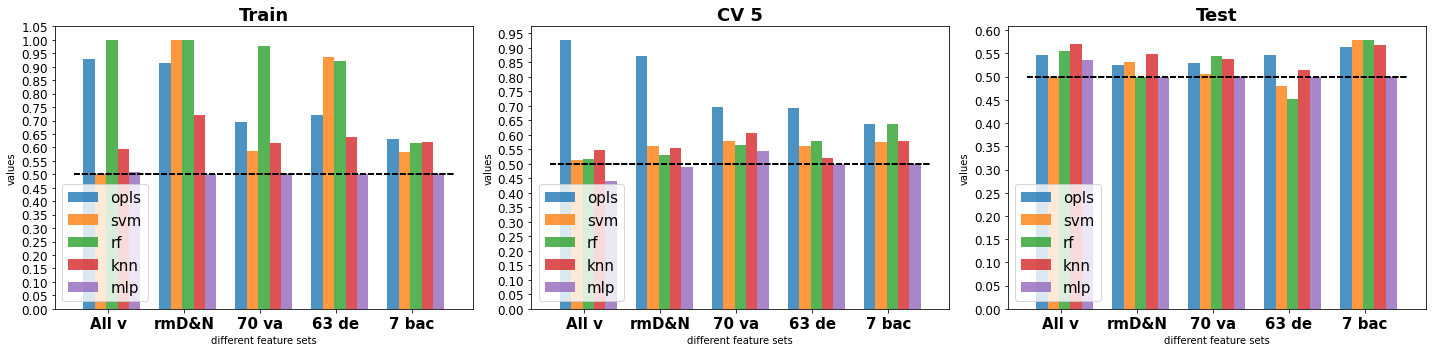

In [13]:
combinations = [(False, False)]
all_test_dicts = dict()
vectorizer = 'word2vec'
random_state = 42
cv=5
split_size = 0.2
n_iter = 220
dicts = [dict_all, dict_70v, dict_63d, dict_7b]
dict_names = ['All variables','70 variables','63 descriptors', '7 back. variables']

for combs in combinations:
    suffix_41 = combs[0]
    without_digits = combs[1]
    print("started for trimming ", suffix_41)
    results = dict(); opls_dict = dict(); svm_dict = dict(); rf_dict = dict(); knn_dict = dict(); mlp_dict = dict(); 
    dict_best_params = dict()

    best_test = [0 for i in range(len(dict_names))]
    best_test_model = ['' for i in range(len(dict_names))]

    for _dict in range(len(dicts)):
        data_list, _, _ = nlp_hlp.get_data_from_main_dict(dicts[_dict], stemm=True, 
            return_corpus_sent=False, return_corpus_token=False, without_digits=without_digits, suffix_41=suffix_41)

        data_vectorized= list()
        max_len=0 # the maximum possible length of features of a patient
        features = list()
        for patient_text in data_list:
            temp = np.empty((0,))
            for word in patient_text.split():
                try:
                    temp = np.append(temp, values=wv[word].mean())
                    features.append(word)
                except:
                    print("key {0} not found in dict {1}".format(word, dict_names[_dict]))
            if len(temp)>max_len:
                max_len=len(temp)
            data_vectorized.append(temp)
            
        tmp = list()
        for data_array in data_vectorized:
            if len(data_array) < max_len:
                data_array = np.append(data_array, values=np.zeros((max_len-len(data_array), ))) 
            tmp.append(data_array)  
        del data_vectorized
        data_vectorized = tmp
        del tmp
        
        min_max = preprocessing.MinMaxScaler()
        min_max_data = min_max.fit_transform(data_vectorized)
        
        x_train, x_test, y_train, y_test = ml_hlp.get_train_test_split_data(min_max_data, labels, stratify = labels,
                                                      test_size=split_size, random_state=random_state, shuffle = True)
        X_train = ml_hlp.get_csr_matrix(x_train)
        X_test = ml_hlp.get_csr_matrix(x_test)

        Y_train = np.array(y_train, dtype='float')
        Y_test = np.array(y_test, dtype='float')
        del x_train, x_test, y_train, y_test, min_max_data, data_vectorized

        print("Number of features in this dict: ", len(features))
        print("Maximum number of features for each patient: ", max_len)

        opls = OPLS(2)
        opls.fit(X_train, Y_train)
        z_train = opls.transform(X_train)
        z_test = opls.transform(X_test)
        pls = PLSRegression(1)
        pls.fit(z_train, Y_train)

        y_pred = cross_val_predict(pls, z_train, Y_train, cv=StratifiedKFold(cv))
        threshed_values = np.array(y_pred)
        best = 0
        best_thresh = 0
        for thresh in np.unique(y_pred):
            threshed_values[y_pred<thresh]=1
            threshed_values[y_pred>=thresh]=2
            score = roc_auc_score(Y_train, threshed_values)
            if score > best:
                best=score
                best_thresh=thresh
                
        std = y_pred[y_pred>=best_thresh].std()
        
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        cv_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_train)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        train_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_test)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        test_score = roc_auc_score(Y_test, y_pred)
        f1_Score = f1_score(Y_test, y_pred)
        
        dict_best_params['opls '+ dict_names[_dict]] = {'best_thresh': best_thresh}
        
        opls_dict[dict_names[_dict]] = {'Train': [train_score], 
                            'CV 5': [cv_score, std],
                            'Test' : [test_score, f1_Score]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'opls'

        del opls, pls, y_pred, threshed_values, std, cv_score, train_score, test_score, f1_Score
        
        svm = SVC(probability=True, 
              random_state=random_state, class_weight = "balanced")

        param_distributions = {"gamma": loguniform(0.0001, 2),
                               "kernel": ['rbf', 'linear'],
                               "degree": [2,3],
                               "C": loguniform(0.001, 2)
                               }
        search = RandomizedSearchCV(svm, param_distributions,
                                       n_iter= n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score='raise',
                                       random_state=random_state).fit(X_train, Y_train)
        svm = search.best_estimator_
        dict_best_params['svm '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(svm, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, svm)

        svm_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, svm)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score, f1_score(Y_test, svm.predict(X_test))]}
        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'svm'

        del svm
        rf = RandomForestClassifier(random_state=random_state, 
                                    class_weight = "balanced", 
                                    max_features='auto',
                                    criterion='entropy')

        param_distributions = {"max_depth": [1, 2, 3, None],
                               "min_samples_split": randint(2, 14),
                               "min_samples_leaf": randint(1, 14),
                               "ccp_alpha": loguniform(0.0001, 1)
    #                            "max_features": ['auto', 'sqrt','log2']
                              }
        search = RandomizedSearchCV(rf, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)
        rf = search.best_estimator_
        dict_best_params['rf '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(rf, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, rf)
        rf_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, rf)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, rf.predict(X_test))]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'rf'

        del rf
        knn = KNeighborsClassifier()
        param_distributions = {"n_neighbors": [3,4,5,7,10],
                               "weights": ['uniform', 'distance'],
                               "leaf_size": list(range(1,12)),
                               "p": list(range(1,3))
                              }
        search = RandomizedSearchCV(knn, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        knn = search.best_estimator_
        dict_best_params['knn '+ dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(knn, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, knn)
        knn_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, knn)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, knn.predict(X_test))]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'knn'

        del knn
        mlp = MLPClassifier(random_state=random_state, max_iter=1200, 
                            learning_rate='adaptive', batch_size='auto',
                            early_stopping=True);

        param_distributions = {"hidden_layer_sizes": [(7,3), (5,2), (100,)],
                               "activation": ['tanh', 'logistic','relu'],
                               "solver": ['adam', 'lbfgs'],
                               "alpha":  loguniform(0.0001, 1)
                               };

        search = RandomizedSearchCV(mlp, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        mlp = search.best_estimator_
        dict_best_params['mlp '+dict_names[_dict]] = search.best_params_

        cv_score = cross_val_score(mlp, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, mlp)
        mlp_dict[dict_names[_dict]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, mlp)], 
                            'CV 5': [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, mlp.predict(X_test))]}

        if test_score > best_test[_dict]:
            best_test[_dict] = test_score
            best_test_model[_dict] = 'mlp'

    #     print('%d dict is done'%_dict)
        del X_train, Y_train, X_test, Y_test
        
    print("The set with trimm {0} done.".format(suffix_41))
    print("Best test models: ", best_test_model)
    print("With test scores: ", best_test)
    print("")
    #############################################################################
    to_be_saved_dicts = [opls_dict, svm_dict, rf_dict, knn_dict, mlp_dict]
    names = ['opls', 'svm', 'rf', 'knn', 'mlp']
    save_file_name = r"...\MEX\PekLung\results\word2vec"

    for i in range(len(to_be_saved_dicts)):
        results[names[i]] = to_be_saved_dicts[i]
    file_path = save_file_name + r"\best_results\only_own_corpus_{0}_without_digits_{1}".format(str(suffix_41), str(without_digits)) 

    hlp.write_dict_as_json_file(results, 
                                file_path = file_path)

    file_path = save_file_name + r"\best_params\only_own_corpus_{0}_without_digits_{1}".format(str(suffix_41), str(without_digits))
    hlp.write_dict_as_json_file(dict_best_params, 
                                file_path = file_path)
    ###############################################################################
    approaches = list(results.keys()) # ['opls', 'svm', 'rf', 'knn', 'mlp']
    sets_names = list(results[approaches[0]].keys()) # ['All variables', '70 variables', '7 back. variables', '63 descriptors ']
    x_labels = [set_name[0:5] for set_name in sets_names] # ['All v', '70 va', '7 bac', '63 de']
    splits_names = list(results[approaches[0]][sets_names[0]].keys()) # ['Train', 'CV 6', 'Test']
    plot_dict = dict()
    for split in splits_names:
        tmp_dict_approach = dict()
        for approach_idx in range(len(approaches)):
            df = pd.DataFrame(results[approaches[approach_idx]])
            tmp_dict_set = dict()
            for column in df.columns:
                tmp_dict_set[column] = df.loc[split, column][0]
            tmp_dict_approach[approaches[approach_idx]] = tmp_dict_set
        plot_dict[split] = tmp_dict_approach

    plt.figure(figsize=(20,5))
    for i in range(len(splits_names)):
        split_name = splits_names[i]
        result_df = pd.DataFrame(plot_dict[split_name])

        approaches = result_df.columns
        variables = list(result_df[approaches[i]].index)

        for ii in range(len(approaches)):
            plt.subplot(1,3,i+1)
            plt.xticks(np.arange(len(x_labels))+0.25, x_labels, weight = 'semibold', fontsize=15)
            plt.yticks(np.arange(0,1.1,0.05), weight = 'roman', fontsize=12)
            plt.bar(x = np.arange(len(variables))+(ii*0.15), height=result_df[approaches[ii]], width=0.15, 
                    label = approaches[ii], alpha=0.8)
            plt.title('{}'.format(split_name), fontsize=18, weight = 'semibold')

            plt.legend(loc='lower left', fontsize=15)#bbox_to_anchor=(1., 1.))#)
            plt.ylabel('values')
            plt.xlabel('different feature sets')
            plt.plot([-0.2, 4.8], [0.5, 0.5], "k--")
    save_file_name = r"...\MEX\data_imgs\results_word2vec\new_results"
    plt.tight_layout()
    file_path = save_file_name + r"\only_own_corpus_{0}_without_digits_{1}".format(str(suffix_41), str(without_digits))+".pdf"
    plt.savefig(file_path)
#     plt.show()
    all_test_dicts[str(combs)] = plot_dict['Test']
    
file_path = r"...\MEX\PekLung\results\word2vec\best_results\only_own_corpus"
hlp.write_dict_as_json_file(all_test_dicts, 
                            file_path = file_path)